## Lung Nodule Bounding Box Locator
This notebook focuses on trying to draw a bounding box around a lung nodule. The data is composed of dicom files with corresponding xml files that contain the bounding box labels.
The data was pulled from:
https://www.cancerimagingarchive.net/collections/

The monai model was based primarily on these two examples:
https://colab.research.google.com/drive/1wy8XUSnNWlhDNazFdvGBHLfdkGvOHBKe#scrollTo=Ty_YA-cLBpyr
https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb

Two other additional sources helped me try to build models without using Monai, using pytorch and keras respectively:
https://towardsdatascience.com/bounding-box-prediction-from-scratch-using-pytorch-a8525da51ddc
https://github.com/jrieke/shape-detection/blob/master/single-rectangle.ipynb


Special thanks to Professor Turner for guiding me through this project throughout the semester.




In [1]:
import os
import shutil
import numpy as np
import itk

from PIL import Image
import tempfile
from xml.etree import ElementTree
from monai.data import ITKReader, NibabelReader, PILReader
from monai.transforms import LoadImage, LoadImaged, AddChanneld, Resized, ToTensord, Compose
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    CropForegroundd,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensity,
    Spacingd,
    AddChannel,
    ToTensor,
)
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from monai.utils import first, set_determinism
from VisualizationTools import utils
from VisualizationTools.get_data_from_XML import *
from VisualizationTools.getUID import *
from VisualizationTools.get_gt import *
from VisualizationTools.roi2rect import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
import torch
from monai.networks.nets import densenet121
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import keras


print_config()

MONAI version: 0.3.0
Python version: 3.8.2 (default, Jul 16 2020, 14:00:26)  [GCC 9.3.0]
OS version: Linux (4.4.0-18362-Microsoft)
Numpy version: 1.19.2
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 7.2.0
Tensorboard version: 2.4.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.7.0
ITK version: 5.1.1
tqdm version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
#Convert a numpy 3d array of a bitmap of an rgb image to grayscale
#using the formula (0.3 * R) + (0.59 * G) + (0.11 * B) 
def rgb_bmp_togray(imgbmp):
#     l, w, cols = imgbmp.shape
#     graybmp = np.zeros((l,w));
    r = imgbmp[:,:,0]
    g = imgbmp[:,:,1]
    b = imgbmp[:,:,2]
    graybmp = np.multiply(0.3*r, 0.59*g)
    graybmp = np.multiply(graybmp, .11*b)
    
#     for i in range(l):
#         for j in range(w):
#             r = imgbmp[i][j][0]
#             g = imgbmp[i][j][1]
#             b = imgbmp[i][j][2]
#             graybmp[i][j] = (0.3 * r) + (0.59 * g) + (0.11 * b)
    return graybmp

In [30]:
#Intersection over union calculation given two bounding boxes
def IOU(bbox1, bbox2):
    xmin1, ymin1, xmax1, ymax1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    xmin2, ymin2, xmax2, ymax2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    x_intersection = 0
    if xmin1 <= xmax2 and xmin2 <= xmax1:
        x_intersection = min(xmax1, xmax2) - max(xmin1, xmin2)
        
    y_intersection = 0
    if ymin1 <= ymax2 and ymin2 <= ymax1:
        y_intersection = min(ymax1, ymax2) - max(ymin1, ymin2)
    
    intersection = x_intersection * y_intersection
    
    if intersection == 0:
        return 0
    
    union = (xmax1-xmin1)*(ymax1-ymin1) + (xmax2-xmin2)*(ymax2-ymin2) - intersection
    
    return intersection/union
    

    return I / U

# Extracting the data
## Data Source
The data has been downloaded from https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70224216.
The data is composed of DICOM files, and they have corresponding XML files containing annotations. The page
also provides a downloader to locally download all 132GB of data, along with a visualization tool for viewing 
the dicom files with bounding boxes drawn based on corresponding annotations.

## Loading the data
The visualization tool provided in Python is utilized here to extract the data and their annotations to 
prepare the data for training the model. 
Note: The visualization tool has been slightly modified for use in this notebook and its modified version 
is stored along with the notebook.

In order to run this notebook, the data must be downloaded and the variables dicom_path and annotation_path must
be changed to their respective locations on the local platform. 

[[286. 310. 355. 402.   1.   0.   0.   0.]]


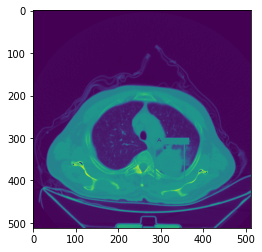

In [35]:
#print out an example dicom with the bounding box drawn
dicom_path = "/mnt/d/Lungs/Lung-PET-CT-Dx/"
annotation_path = "/mnt/d/Lungs/Lung-PET-CT-Dx-Annotations-XML-Files-rev10152020/Annotation/"
anfilenames = os.listdir(annotation_path)
lungfilenames = os.listdir(dicom_path)
num_classes = 4
for aname in anfilenames:
    anpath = annotation_path + aname
    lungpath = dicom_path + "Lung_Dx-" + aname
    if not os.path.isdir(lungpath):
        print("missing: ", lungpath)
        continue
    lungs = getUID_path(lungpath)
    annotations = XML_preprocessor(anpath, num_classes=num_classes).data
    for k, v in annotations.items():
        key = k[:-4]
        if key not in lungs:
            print("missing key: ", k)
            continue
        dcm_path, dcm_name = lungs[k[:-4]]
        matrix, frame_num, width, height, ch = loadFile(dcm_path)
        img_bitmap = MatrixToImage(matrix[0], ch)
        print(v)
        test = roi2rect(img_name=dcm_name, img_np=img_bitmap, img_data=v, label_list=['A', 'B', 'D', 'G'])
        plt.imshow(test)
        break
    break

In [4]:
#load the data
# the x values are 512x512 image bitmaps converted to grayscale and then flattened to 1d arrays
#the y values are 4 values: xmin, ymin, xmax, ymax
anfilenames = os.listdir(annotation_path)
lungfilenames = os.listdir(dicom_path)
num_classes = 4
xtotal = []
ytotal = []
for aname in anfilenames:
    if np.random.random() > .1:
        continue
    anpath = annotation_path + aname
    lungpath = dicom_path + "Lung_Dx-" + aname
    if not os.path.isdir(lungpath):
        print("missing: ", lungpath)
        continue
    lungs = getUID_path(lungpath)
    annotations = XML_preprocessor(anpath, num_classes=num_classes).data
    for k, v in annotations.items():
        
        key = k[:-4]
        if key not in lungs:
            print("missing key: ", k)
            continue
        dcm_path, dcm_name = lungs[k[:-4]]
        matrix, frame_num, width, height, ch = loadFile(dcm_path)
        img_bitmap = MatrixToImage(matrix[0], ch)
        xbmp = img_bitmap
        if len(img_bitmap.shape) > 2: #assume bitmap is rgb
            xbmp = rgb_bmp_togray(img_bitmap)
        xbmp = xbmp.reshape(np.prod(xbmp.shape))/255
        xtotal.append(xbmp)

        #extract xmin, ymin, xmax, ymax in that order
        ytotal.append(np.array([v[0][0], v[0][1], v[0][2], v[0][3]]))
    

        
        
        
xtotal = np.array(xtotal)
ytotal = np.array(ytotal)
print(xtotal.shape)
print(ytotal.shape)



missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.191960383852949572073542121650.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.189461106584515308411598081166.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.318847255132443758677257699141.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.640989394534645008183784040296.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.109383104632194712329741167552.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.112037913552391298939729755552.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.112638608219561655996356119916.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.139937291890325357393663792926.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.189150587860964704966835065099.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.209685246046991299310138370274.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.214645774649513000878448653839.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.227534499135203089105161229642.xml
miss

In [14]:
#split the data into training, validation, and testing data sets
Xtemp, Xtest, Ytemp, Ytest = train_test_split(xtotal, ytotal, train_size = .9, random_state=2021)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtemp, Ytemp, train_size = 8/9, random_state=2021)

## Keras model
Since the monai model was not successful, I created a simple model using keras as well.
It uses mean squared error loss and simply requires the numpy arrays as the data.
After training on 1000 epochs, the loss went from 60000 to around 7000. 

In [61]:
#build the keras model
modelk = Sequential([
        Dense(200, input_dim=Xtrain.shape[-1]), 
        Activation('relu'), 
        Dropout(0.2), 
        Dense(Ytrain.shape[-1])
    ])
modelk.compile('adadelta', 'mse')
#modelk.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy())

In [63]:
modelk.fit(Xtrain, Ytrain, epochs=1000, validation_data=(Xval, Yval), verbose=2)

Epoch 1/1000
89/89 - 44s - loss: 68299.9141 - val_loss: 62956.9492
Epoch 2/1000
89/89 - 40s - loss: 61531.7969 - val_loss: 60455.4141
Epoch 3/1000
89/89 - 40s - loss: 59632.1953 - val_loss: 59745.1523
Epoch 4/1000
89/89 - 40s - loss: 58746.4922 - val_loss: 59487.4375
Epoch 5/1000
89/89 - 40s - loss: 58277.3164 - val_loss: 58960.9141
Epoch 6/1000
89/89 - 40s - loss: 57757.9180 - val_loss: 58572.1016
Epoch 7/1000
89/89 - 40s - loss: 57430.8750 - val_loss: 58350.3594
Epoch 8/1000
89/89 - 40s - loss: 57027.0859 - val_loss: 58153.3828
Epoch 9/1000
89/89 - 40s - loss: 56678.0273 - val_loss: 57547.5000
Epoch 10/1000
89/89 - 40s - loss: 56321.0820 - val_loss: 57276.9375
Epoch 11/1000
89/89 - 40s - loss: 56018.4961 - val_loss: 56934.8477
Epoch 12/1000
89/89 - 40s - loss: 55675.1797 - val_loss: 56577.3555
Epoch 13/1000
89/89 - 40s - loss: 55306.8359 - val_loss: 56233.6523
Epoch 14/1000
89/89 - 39s - loss: 54985.3984 - val_loss: 55949.6055
Epoch 15/1000
89/89 - 40s - loss: 54772.0195 - val_loss: 

Epoch 122/1000
89/89 - 40s - loss: 31574.7324 - val_loss: 31910.6133
Epoch 123/1000
89/89 - 39s - loss: 31167.1211 - val_loss: 32007.1914
Epoch 124/1000
89/89 - 40s - loss: 31122.8027 - val_loss: 31593.1992
Epoch 125/1000
89/89 - 39s - loss: 30887.0625 - val_loss: 31497.5273
Epoch 126/1000
89/89 - 39s - loss: 30815.4844 - val_loss: 31628.2559
Epoch 127/1000
89/89 - 40s - loss: 30546.7656 - val_loss: 31757.2441
Epoch 128/1000
89/89 - 40s - loss: 30498.3184 - val_loss: 31271.0840
Epoch 129/1000
89/89 - 39s - loss: 30612.4297 - val_loss: 31045.2246
Epoch 130/1000
89/89 - 39s - loss: 30272.4414 - val_loss: 30797.2031
Epoch 131/1000
89/89 - 40s - loss: 30233.1328 - val_loss: 30681.3145
Epoch 132/1000
89/89 - 39s - loss: 29948.2578 - val_loss: 30628.8145
Epoch 133/1000
89/89 - 39s - loss: 29860.2598 - val_loss: 30533.7031
Epoch 134/1000
89/89 - 39s - loss: 29878.3574 - val_loss: 30464.0957
Epoch 135/1000
89/89 - 39s - loss: 29716.4551 - val_loss: 30471.2812
Epoch 136/1000
89/89 - 39s - loss:

Epoch 241/1000
89/89 - 39s - loss: 21429.0332 - val_loss: 21779.5156
Epoch 242/1000
89/89 - 39s - loss: 21323.1094 - val_loss: 21711.5723
Epoch 243/1000
89/89 - 40s - loss: 21369.0195 - val_loss: 21786.6758
Epoch 244/1000
89/89 - 39s - loss: 21308.0508 - val_loss: 21545.9980
Epoch 245/1000
89/89 - 39s - loss: 21188.8359 - val_loss: 21726.3359
Epoch 246/1000
89/89 - 39s - loss: 21171.5938 - val_loss: 21674.4238
Epoch 247/1000
89/89 - 40s - loss: 21439.3574 - val_loss: 21354.2305
Epoch 248/1000
89/89 - 39s - loss: 21020.7324 - val_loss: 21273.2930
Epoch 249/1000
89/89 - 40s - loss: 21190.0664 - val_loss: 21206.8770
Epoch 250/1000
89/89 - 40s - loss: 21131.1328 - val_loss: 21101.8887
Epoch 251/1000
89/89 - 39s - loss: 20931.5605 - val_loss: 21367.9062
Epoch 252/1000
89/89 - 40s - loss: 20907.0879 - val_loss: 21149.5996
Epoch 253/1000
89/89 - 40s - loss: 20853.7930 - val_loss: 21150.0117
Epoch 254/1000
89/89 - 39s - loss: 20724.4551 - val_loss: 21180.3203
Epoch 255/1000
89/89 - 40s - loss:

Epoch 360/1000
89/89 - 39s - loss: 16523.6641 - val_loss: 17331.6719
Epoch 361/1000
89/89 - 39s - loss: 16537.2852 - val_loss: 17015.8477
Epoch 362/1000
89/89 - 39s - loss: 16617.0098 - val_loss: 16945.6230
Epoch 363/1000
89/89 - 39s - loss: 16452.5977 - val_loss: 17254.9824
Epoch 364/1000
89/89 - 39s - loss: 16334.2637 - val_loss: 16542.3223
Epoch 365/1000
89/89 - 40s - loss: 16598.6777 - val_loss: 16958.1055
Epoch 366/1000
89/89 - 40s - loss: 16448.0684 - val_loss: 16808.3496
Epoch 367/1000
89/89 - 39s - loss: 16276.2969 - val_loss: 16873.0117
Epoch 368/1000
89/89 - 39s - loss: 16348.2891 - val_loss: 16677.1816
Epoch 369/1000
89/89 - 39s - loss: 16196.4121 - val_loss: 16957.7734
Epoch 370/1000
89/89 - 39s - loss: 16274.4990 - val_loss: 16790.8027
Epoch 371/1000
89/89 - 40s - loss: 16271.3691 - val_loss: 16764.5176
Epoch 372/1000
89/89 - 39s - loss: 16190.2402 - val_loss: 16909.7617
Epoch 373/1000
89/89 - 39s - loss: 16085.5039 - val_loss: 16667.5586
Epoch 374/1000
89/89 - 39s - loss:

Epoch 479/1000
89/89 - 39s - loss: 13115.9424 - val_loss: 14935.5381
Epoch 480/1000
89/89 - 39s - loss: 13059.2021 - val_loss: 15070.7627
Epoch 481/1000
89/89 - 39s - loss: 13020.6768 - val_loss: 14844.7949
Epoch 482/1000
89/89 - 40s - loss: 12981.7656 - val_loss: 15047.3438
Epoch 483/1000
89/89 - 40s - loss: 12888.1621 - val_loss: 14365.2910
Epoch 484/1000
89/89 - 39s - loss: 12853.7627 - val_loss: 14586.5703
Epoch 485/1000
89/89 - 39s - loss: 12881.5596 - val_loss: 14807.1055
Epoch 486/1000
89/89 - 39s - loss: 13048.4268 - val_loss: 14811.2266
Epoch 487/1000
89/89 - 39s - loss: 12892.4717 - val_loss: 15046.3887
Epoch 488/1000
89/89 - 39s - loss: 12824.8613 - val_loss: 14931.4814
Epoch 489/1000
89/89 - 39s - loss: 12856.0674 - val_loss: 14975.4932
Epoch 490/1000
89/89 - 39s - loss: 12891.0791 - val_loss: 14771.6279
Epoch 491/1000
89/89 - 39s - loss: 12770.6318 - val_loss: 15218.7754
Epoch 492/1000
89/89 - 40s - loss: 12820.1650 - val_loss: 14347.9160
Epoch 493/1000
89/89 - 39s - loss:

Epoch 598/1000
89/89 - 39s - loss: 10689.4160 - val_loss: 14941.3877
Epoch 599/1000
89/89 - 39s - loss: 10655.3057 - val_loss: 15730.1387
Epoch 600/1000
89/89 - 40s - loss: 10646.1221 - val_loss: 15105.6484
Epoch 601/1000
89/89 - 39s - loss: 10596.0713 - val_loss: 14596.4492
Epoch 602/1000
89/89 - 39s - loss: 10644.5312 - val_loss: 15192.1484
Epoch 603/1000
89/89 - 39s - loss: 10553.2188 - val_loss: 15614.6914
Epoch 604/1000
89/89 - 39s - loss: 10530.0195 - val_loss: 14549.0762
Epoch 605/1000
89/89 - 39s - loss: 10464.6328 - val_loss: 14942.1758
Epoch 606/1000
89/89 - 39s - loss: 10592.0029 - val_loss: 15205.2588
Epoch 607/1000
89/89 - 40s - loss: 10479.1006 - val_loss: 15040.5703
Epoch 608/1000
89/89 - 39s - loss: 10423.6826 - val_loss: 15638.2891
Epoch 609/1000
89/89 - 40s - loss: 10522.4229 - val_loss: 14597.5098
Epoch 610/1000
89/89 - 39s - loss: 10455.3535 - val_loss: 15892.5986
Epoch 611/1000
89/89 - 39s - loss: 10442.1836 - val_loss: 15794.1689
Epoch 612/1000
89/89 - 40s - loss:

Epoch 718/1000
89/89 - 39s - loss: 9090.0869 - val_loss: 18463.9414
Epoch 719/1000
89/89 - 39s - loss: 9155.5498 - val_loss: 17071.2324
Epoch 720/1000
89/89 - 39s - loss: 9115.5908 - val_loss: 17793.3672
Epoch 721/1000
89/89 - 40s - loss: 9136.1123 - val_loss: 17650.4414
Epoch 722/1000
89/89 - 40s - loss: 9118.5918 - val_loss: 18198.1230
Epoch 723/1000
89/89 - 40s - loss: 9181.3223 - val_loss: 17505.7266
Epoch 724/1000
89/89 - 40s - loss: 9150.9189 - val_loss: 18060.3887
Epoch 725/1000
89/89 - 39s - loss: 9070.4424 - val_loss: 18021.8320
Epoch 726/1000
89/89 - 39s - loss: 9246.7568 - val_loss: 18702.9727
Epoch 727/1000
89/89 - 40s - loss: 9156.1904 - val_loss: 17658.2969
Epoch 728/1000
89/89 - 40s - loss: 9036.6865 - val_loss: 18098.1406
Epoch 729/1000
89/89 - 39s - loss: 9111.8076 - val_loss: 17628.6230
Epoch 730/1000
89/89 - 39s - loss: 9034.9873 - val_loss: 17880.4512
Epoch 731/1000
89/89 - 39s - loss: 9021.2520 - val_loss: 19015.0898
Epoch 732/1000
89/89 - 39s - loss: 9002.3213 - v

Epoch 839/1000
89/89 - 39s - loss: 8268.2773 - val_loss: 22285.7246
Epoch 840/1000
89/89 - 40s - loss: 8192.9219 - val_loss: 19274.4766
Epoch 841/1000
89/89 - 40s - loss: 8274.7188 - val_loss: 20551.6758
Epoch 842/1000
89/89 - 39s - loss: 8184.3345 - val_loss: 21550.0371
Epoch 843/1000
89/89 - 39s - loss: 8180.6299 - val_loss: 23153.6816
Epoch 844/1000
89/89 - 39s - loss: 8207.8750 - val_loss: 22896.8613
Epoch 845/1000
89/89 - 40s - loss: 8226.0996 - val_loss: 22905.3086
Epoch 846/1000
89/89 - 40s - loss: 8257.6396 - val_loss: 22536.8516
Epoch 847/1000
89/89 - 40s - loss: 8217.1641 - val_loss: 21583.2715
Epoch 848/1000
89/89 - 39s - loss: 8173.8555 - val_loss: 21502.7441
Epoch 849/1000
89/89 - 39s - loss: 8105.9399 - val_loss: 23064.5527
Epoch 850/1000
89/89 - 39s - loss: 8191.8057 - val_loss: 22082.4648
Epoch 851/1000
89/89 - 39s - loss: 8199.0361 - val_loss: 22539.4922
Epoch 852/1000
89/89 - 40s - loss: 8164.8716 - val_loss: 20182.7598
Epoch 853/1000
89/89 - 39s - loss: 8222.6504 - v

Epoch 960/1000
89/89 - 40s - loss: 7577.7598 - val_loss: 27451.2520
Epoch 961/1000
89/89 - 40s - loss: 7538.2549 - val_loss: 27715.8477
Epoch 962/1000
89/89 - 39s - loss: 7578.4941 - val_loss: 26256.2559
Epoch 963/1000
89/89 - 40s - loss: 7670.5659 - val_loss: 27387.0273
Epoch 964/1000
89/89 - 40s - loss: 7647.7031 - val_loss: 28536.2578
Epoch 965/1000
89/89 - 40s - loss: 7556.9844 - val_loss: 27229.9688
Epoch 966/1000
89/89 - 40s - loss: 7533.5405 - val_loss: 29310.8906
Epoch 967/1000
89/89 - 40s - loss: 7561.7368 - val_loss: 27026.4297
Epoch 968/1000
89/89 - 40s - loss: 7553.4683 - val_loss: 26647.7520
Epoch 969/1000
89/89 - 40s - loss: 7521.4502 - val_loss: 28639.6934
Epoch 970/1000
89/89 - 39s - loss: 7592.0352 - val_loss: 28193.9473
Epoch 971/1000
89/89 - 39s - loss: 7508.0098 - val_loss: 28510.3711
Epoch 972/1000
89/89 - 39s - loss: 7549.4370 - val_loss: 26082.2441
Epoch 973/1000
89/89 - 39s - loss: 7520.5503 - val_loss: 27225.6133
Epoch 974/1000
89/89 - 39s - loss: 7586.7495 - v

In [32]:
#invert any bounding box that is backwards
ypred = modelk.predict(Xtest)
for box in ypred:
    if box[0] > box[2]:
        temp = box[0]
        box[0] = box[2]
        box[2] = temp
    if box[1] > box[3]:
        temp = box[1]
        box[1] = box[3]
        box[3] = box[1]

In [67]:
ious = [IOU(ypred[i], Ytest[i]) for i in range(len(Ytest))]
print("Max IOU:", max(ious))
print("Min IOU:",min(ious))
print("Total testing length:", len(ious))
print(IOU(ypred[imin], Ytest[imin]))
print("Average IOU: {}".format(sum(ious)/len(ious)))
hitious = [iou for iou in ious if iou != 0]
print("Total nonzero IOUs:", len(hitious))
print("Average IOU without misses: {}".format(sum(hitious)/len(hitious)))

0.7814383783452259
0
356
[5.3674083 5.7848163 7.555353  9.166866 ]
[155. 337. 194. 377.]
0
Average IOU: 0.10010199881530522
114
Average IOU without misses: 0.3125992243706023


[array([308.16970825, 190.59907532, 374.75125122, 295.76617432,
         1.        ,   0.        ,   0.        ,   0.        ])]


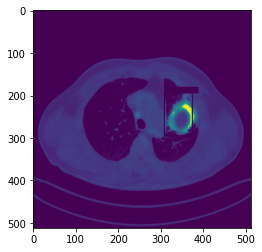

In [65]:
#display image of best prediction
imax = ious.index(max(ious))
data = [np.hstack((np.asarray(ypred[imax]), np.asarray([1,0,0,0])))]
img_bitmap = Xtest[imax]*255
img_bitmap = img_bitmap.reshape((512,512))
print(data)
test = roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)

[5.3674083 5.7848163 7.555353  9.166866 ] [155. 337. 194. 377.]


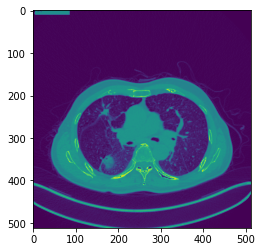

In [66]:
#display example of prediction that missed completely
imin = ious.index(min(ious))
print(ypred[imin], Ytest[imin])
data = [np.hstack((np.asarray(ypred[imin]), np.asarray([1,0,0,0])))]
img_bitmap = Xtest[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)

[356.60684 265.65164 375.53088 334.30182] [371. 286. 417. 343.]


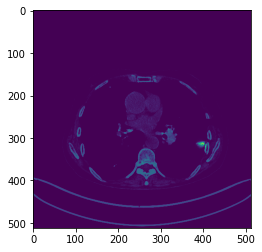

In [68]:
#display image of worst prediction that didn't miss completely
imin = hitious.index(min(hitious))
print(ypred[imin], Ytest[imin])
data = [np.hstack((np.asarray(ypred[imin]), np.asarray([1,0,0,0])))]
img_bitmap = Xtest[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)

## Monai Code
The following cells are the entirety of the monai code. It includes a transform meant to set up the data for tensor use, along
with scaling. It uses monai to load and transform the data and set up loader for the training, validation, and testing data.
The code then follows a basic pipeline to train the model. Training the model was too memory intensive for the computer I ran it on without cutting out too much of the data, and overall the model did not perform well on the small amount of data it could handle. It definitely has potential, but needs more tuning up before it is effective.

In [13]:
#compose the simple monai transform
transforms = Compose([
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [ ]:
#simple class for data, based on that in MedNIST example
class LungDataset(Dataset):

    def __init__(self, image_bitmap, labels, transforms):
        self.image_bitmap = image_bitmap
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_bitmap)

    def __getitem__(self, index):
        return self.transforms(self.image_bitmap[index]), self.labels[index]

    
    #load the data using monai
train_ds = LungDataset(Xtrain, Ytrain, transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True)

val_ds = LungDataset(Xval, Yval, transforms)
val_loader = DataLoader(val_ds, batch_size=300)

test_ds = LungDataset(Xtest, Ytest, transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [8]:
#set up the device and model
device = torch.device("cpu")
model = densenet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=4
).to(device)
loss_function = DiceLoss(jaccard=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [20]:
#standard model training pipeline
epoch_num = 10
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images.float())], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            auc_metric = compute_meandice(y_pred,y)
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred, y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")

----------
epoch 1/10
1/0, train_loss: 0.6259
epoch 1 average loss: 0.6259
----------
epoch 2/10
1/0, train_loss: 0.6255
epoch 2 average loss: 0.6255
saved new best metric model
current epoch: 2 current AUC: 0.5716 current accuracy: 0.0000 best AUC: 0.5716 at epoch: 2
----------
epoch 3/10
1/0, train_loss: 0.6251
epoch 3 average loss: 0.6251
----------
epoch 4/10
1/0, train_loss: 0.6248
epoch 4 average loss: 0.6248
current epoch: 4 current AUC: 0.5716 current accuracy: 0.0000 best AUC: 0.5716 at epoch: 2
----------
epoch 5/10
1/0, train_loss: 0.6245
epoch 5 average loss: 0.6245
----------
epoch 6/10
1/0, train_loss: 0.6243
epoch 6 average loss: 0.6243
current epoch: 6 current AUC: 0.5716 current accuracy: 0.0000 best AUC: 0.5716 at epoch: 2
----------
epoch 7/10
1/0, train_loss: 0.6240
epoch 7 average loss: 0.6240
----------
epoch 8/10
1/0, train_loss: 0.6237
epoch 8 average loss: 0.6237
current epoch: 8 current AUC: 0.5716 current accuracy: 0.0000 best AUC: 0.5716 at epoch: 2
--------